## Install requirements

In [1]:
%%capture
!pip install spacy
!pip install pyLDAvis

## Download kaggle token and mount Google drive

In [2]:
from google.colab import files
files.upload()

!rm -r ~/.kaggle
!mkdir ~/.kaggle
!mv ./kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json
rm: cannot remove '/root/.kaggle': No such file or directory


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Load data

In [4]:
# Downloading data
!kaggle datasets download -d Cornell-University/arxiv --force

!mkdir Dataset
!cp /content/arxiv.zip /content/Dataset/arxiv.zip
!unzip -q /content/Dataset/arxiv.zip -d /content/Dataset
!rm /content/Dataset/arxiv.zip

 98% 1.12G/1.14G [00:07<00:00, 170MB/s]
100% 1.14G/1.14G [00:07<00:00, 165MB/s]


In [5]:
import pandas as pd
dfs = pd.read_json('/content/Dataset/arxiv-metadata-oai-snapshot.json', lines=True, chunksize = 5e4)

In [6]:
df = pd.DataFrame()
for data in dfs:
  df = pd.concat([df, data[['abstract']]])
  if df.shape[0] > 1e6:
    break

sub_df = df.dropna(subset=['abstract'])


In [7]:
docs = sub_df['abstract'].to_list()[:1000000]

## Preprocessing

In [8]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords


stop_words = stopwords.words('english')
stop_words.extend(['allow', 'almost', 'also', 'approach', 'asume', 'bad', 'behavior',
                  'consider', 'constant', 'control', 'datum', 'density', 'describe',
                  'description', 'direction', 'discuss', 'edu', 'effect',
                  'effective', 'energy', 'example', 'experimental', 'field', 'find',
                  'fine', 'first', 'form', 'from', 'give', 'high', 'investigate',
                  'know', 'known', 'large', 'lead', 'let', 'long', 'low', 'make', 'model',
                  'new', 'non', 'observe', 'obtain', 'paper', 'parameter',
                  'particular', 'point', 'positive', 'present', 'problem',
                  'property', 'propose', 'result', 'sample', 'search', 'show',
                  'small', 'state', 'study', 'subject', 'suggest', 'suppose',
                  'system', 'theory', 'time', 'use', 'well', 'word', 'work'])

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [9]:
from sklearn.feature_extraction.text import CountVectorizer
import numpy as np

cv = CountVectorizer(max_features=500, stop_words=stop_words)
n_wd = np.array(cv.fit_transform(docs).todense()).T
vocabulary = cv.get_feature_names_out()

In [ ]:
tokenized_docs = [cv.get_feature_names_out()[np.bool_(n_wd[:, i].T)] for i in range(len(docs))]

In [11]:
from gensim import corpora
# Mapping from word IDs to words
id2word = corpora.Dictionary(tokenized_docs)

# Prepare Document-Term Matrix
corpus = []
for doc in tokenized_docs:
    corpus.append(id2word.doc2bow(doc))

## NMF (Non-negative Matrix Factorization)

In [12]:
topics_num = 15
iter_over_collection = 15
iter_over_document = 5
num_tokens = 20

In [13]:
# Import dependencies
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
import spacy
import pyLDAvis
import pyLDAvis.gensim_models
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

# Fit NMF model
nmf_model = gensim.models.Nmf(
    corpus = corpus,     
    id2word = id2word, 
    num_topics = topics_num,     # Number of latent topics to extract
    random_state = 100,
    passes = iter_over_collection * iter_over_document,        # N° of passes through the corpus during training
    )

nmf_topics = nmf_model.show_topics(num_topics=15, num_words=num_tokens, formatted=False)
nmf_topics = [[word[0] for word in topic[1]] for topic in nmf_topics]
# Get the topics sorted by sparsity
nmf_model.show_topics()

[(2,
  '0.029*"phase" + 0.026*"quantum" + 0.023*"spin" + 0.022*"magnetic" + 0.021*"temperature" + 0.020*"order" + 0.020*"transition" + 0.019*"states" + 0.015*"coupling" + 0.014*"interaction"'),
 (5,
  '0.028*"space" + 0.023*"case" + 0.022*"prove" + 0.017*"general" + 0.016*"finite" + 0.014*"equations" + 0.013*"solutions" + 0.013*"type" + 0.013*"group" + 0.013*"equation"'),
 (4,
  '0.076*"number" + 0.055*"function" + 0.024*"given" + 0.023*"distribution" + 0.018*"set" + 0.017*"random" + 0.015*"algorithm" + 0.015*"functions" + 0.014*"probability" + 0.014*"size"'),
 (13,
  '0.068*"mass" + 0.020*"masses" + 0.019*"star" + 0.019*"formation" + 0.018*"stellar" + 0.017*"matter" + 0.017*"evolution" + 0.017*"stars" + 0.017*"10" + 0.016*"massive"'),
 (11,
  '0.070*"different" + 0.055*"systems" + 0.031*"may" + 0.030*"however" + 0.027*"many" + 0.015*"provide" + 0.015*"important" + 0.014*"information" + 0.012*"properties" + 0.012*"dynamics"'),
 (7,
  '0.134*"observed" + 0.045*"found" + 0.027*"structure

## BigARTM (LDA, PLSA, ARTM)

In [14]:
%%capture
!pip install bigartm

In [15]:
import artm

bv = artm.BatchVectorizer(data_format='bow_n_wd',
                          n_wd=n_wd,
                          vocabulary=vocabulary)

/usr/local/lib/python3.9/dist-packages/artm/batches_utils.py:227: DeprecationWarning: Please use `spmatrix` from the `scipy.sparse` namespace, the `scipy.sparse.base` namespace is deprecated.
  from scipy.sparse.base import spmatrix


In [16]:
model_plsa = artm.ARTM(num_topics=topics_num, cache_theta=True,
                       scores=[artm.PerplexityScore(name='PerplexityScore',
                                                    dictionary=bv.dictionary)])

model_artm = artm.ARTM(num_topics=topics_num, cache_theta=True,
                       scores=[artm.PerplexityScore(name='PerplexityScore',
                                                    dictionary=bv.dictionary)],
                       regularizers=[artm.SmoothSparseThetaRegularizer(name='SparseTheta',
                                                                       tau=-0.15)])
model_lda = artm.LDA(num_topics=topics_num, cache_theta=True)

model_plsa.scores.add(artm.SparsityPhiScore(name='SparsityPhiScore'))
model_plsa.scores.add(artm.SparsityThetaScore(name='SparsityThetaScore'))
model_plsa.scores.add(artm.TopicKernelScore(name='TopicKernelScore',
                                            probability_mass_threshold=0.3))
model_plsa.scores.add(artm.TopTokensScore(name='TopTokensScore', num_tokens=num_tokens))

model_artm.scores.add(artm.SparsityPhiScore(name='SparsityPhiScore'))
model_artm.scores.add(artm.SparsityThetaScore(name='SparsityThetaScore'))
model_artm.scores.add(artm.TopicKernelScore(name='TopicKernelScore',
                                                  probability_mass_threshold=0.3))
model_artm.scores.add(artm.TopTokensScore(name='TopTokensScore', num_tokens=num_tokens))

model_artm.regularizers.add(artm.SmoothSparsePhiRegularizer(name='SparsePhi', tau=-0.1))
model_artm.regularizers.add(artm.DecorrelatorPhiRegularizer(name='DecorrelatorPhi', tau=1.5e+5))

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [17]:
model_plsa.num_document_passes = iter_over_document
model_artm.num_document_passes = iter_over_document
model_lda.num_document_passes = iter_over_document

model_plsa.initialize(bv.dictionary)
model_plsa.fit_offline(batch_vectorizer=bv, num_collection_passes=iter_over_collection)
model_artm.initialize(bv.dictionary)
model_artm.fit_offline(batch_vectorizer=bv, num_collection_passes=iter_over_collection)
model_lda.initialize(bv.dictionary)
model_lda.fit_offline(batch_vectorizer=bv, num_collection_passes=iter_over_collection)


/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Sparsity Phi: 0.000 (LDA) vs. 0.006 (PLSA) vs. 0.240 (ARTM)
Sparsity Theta: 0.000 (LDA) vs. 0.003 (PLSA) vs. 0.510 (ARTM)
Kernel contrast: 0.737 (PLSA) vs. 0.734 (ARTM)
Kernel purity: 0.647 (PLSA) vs. 0.614 (ARTM)
Perplexity: 232.681 (LDA) vs. 232.364 (PLSA) vs. 229.068 (ARTM)


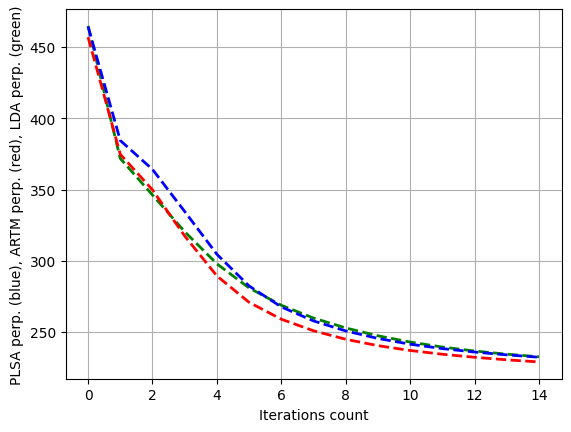

In [18]:
import matplotlib.pyplot as plt
def print_measures(model_plsa, model_artm, model_lda):
    print('Sparsity Phi: {0:.3f} (LDA) vs. {1:.3f} (PLSA) vs. {2:.3f} (ARTM)'.format(
        model_lda.sparsity_phi_last_value,
        model_plsa.score_tracker['SparsityPhiScore'].last_value,
        model_artm.score_tracker['SparsityPhiScore'].last_value))

    print('Sparsity Theta: {0:.3f} (LDA) vs. {1:.3f} (PLSA) vs. {2:.3f} (ARTM)'.format(
        model_lda.sparsity_theta_last_value,
        model_plsa.score_tracker['SparsityThetaScore'].last_value,
        model_artm.score_tracker['SparsityThetaScore'].last_value))

    print('Kernel contrast: {0:.3f} (PLSA) vs. {1:.3f} (ARTM)'.format(
        model_plsa.score_tracker['TopicKernelScore'].last_average_contrast,
        model_artm.score_tracker['TopicKernelScore'].last_average_contrast))

    print('Kernel purity: {0:.3f} (PLSA) vs. {1:.3f} (ARTM)'.format(
        model_plsa.score_tracker['TopicKernelScore'].last_average_purity,
        model_artm.score_tracker['TopicKernelScore'].last_average_purity))

    print('Perplexity: {0:.3f} (LDA) vs. {1:.3f} (PLSA) vs. {2:.3f} (ARTM)'.format(
        model_lda.perplexity_last_value,
        model_plsa.score_tracker['PerplexityScore'].last_value,
        model_artm.score_tracker['PerplexityScore'].last_value))

    plt.plot(range(len(model_lda.perplexity_value)),
             model_lda.perplexity_value, 'g--',
             range(len(model_plsa.score_tracker['PerplexityScore'].value)),
             model_plsa.score_tracker['PerplexityScore'].value, 'b--',
             range(len(model_artm.score_tracker['PerplexityScore'].value)),
             model_artm.score_tracker['PerplexityScore'].value, 'r--', linewidth=2)
    plt.xlabel('Iterations count')
    plt.ylabel('PLSA perp. (blue), ARTM perp. (red), LDA perp. (green)')
    plt.grid(True)
    plt.show()

print_measures(model_plsa, model_artm, model_lda)

In [19]:
# Print results
for topic_name in model_plsa.topic_names:
    print(topic_name + ': ')
    print(model_plsa.score_tracker['TopTokensScore'].last_tokens[topic_name])

topic_0: 
['number', 'distribution', 'size', 'graph', 'bound', 'measure', 'algorithm', 'lower', 'distance', 'graphs', 'two', 'bounds', 'probability', 'upper', 'gaussian', 'maximum', 'variables', 'complexity', 'average', 'higgs']
topic_1: 
['group', 'matrix', 'complex', 'associated', 'certain', 'groups', 'simple', 'examples', 'symmetric', 'operators', 'algebra', 'finite', 'vector', 'open', 'introduce', 'one', 'representation', 'product', 'closed', 'construction']
topic_2: 
['gamma', 'prove', 'class', 'lattice', 'wave', 'spaces', 'limit', 'invariant', 'existence', 'stable', 'spectrum', 'photon', 'weak', 'plane', 'action', 'edge', 'two', 'complete', 'quasi', 'minimal']
topic_3: 
['systems', 'magnetic', 'temperature', 'local', 'fields', 'numerical', 'dynamics', 'flow', 'case', 'critical', 'thermal', 'results', 'transport', 'global', 'induced', 'simulations', 'strongly', 'diffusion', 'two', 'along']
topic_4: 
['structure', 'properties', 'using', 'alpha', 'structures', 'mean', 'measurements'

In [20]:
for topic_name in model_artm.topic_names:
    print(topic_name + ': ')
    print(model_artm.score_tracker['TopTokensScore'].last_tokens[topic_name])

topic_0: 
['number', 'distribution', 'size', 'graph', 'bound', 'algorithm', 'measure', 'lower', 'distance', 'probability', 'bounds', 'upper', 'graphs', 'gaussian', 'maximum', 'set', 'complexity', 'variables', 'two', 'distributions']
topic_1: 
['group', 'matrix', 'complex', 'certain', 'groups', 'algebra', 'associated', 'examples', 'symmetric', 'operators', 'vector', 'open', 'simple', 'representation', 'product', 'construction', 'closed', 'given', 'introduce', 'compact']
topic_2: 
['prove', 'gamma', 'class', 'finite', 'theorem', 'spaces', 'invariant', 'lattice', 'stable', 'existence', 'photon', 'complete', 'action', 'edge', 'every', 'quasi', 'minimal', 'limit', 'plane', 'two']
topic_3: 
['systems', 'magnetic', 'temperature', 'local', 'dynamics', 'fields', 'numerical', 'flow', 'critical', 'thermal', 'simulations', 'transport', 'global', 'results', 'induced', 'diffusion', 'equilibrium', 'strongly', 'case', 'two']
topic_4: 
['structure', 'properties', 'alpha', 'using', 'structures', 'mean',

In [21]:
from operator import itemgetter
member = np.loadtxt("/content/drive/MyDrive/clusters.dat")

with open("/content/drive/MyDrive/taxonomy_leaves.txt") as fn:
    annotations = [l.strip() for l in fn]

ParGen_clusters = []
for cluster in member.T:
    cl = list(sorted(zip(annotations, cluster.flat),
                      key=itemgetter(1), reverse=True))[:num_tokens]
    cl = [w for word in cl for w in word[0].split()]
    ParGen_clusters.append(cl)
    print(cl)

['mathematical', 'finance', 'general', 'physics', 'computational', 'physics', 'general', 'economics', 'statistics', 'and', 'probability', 'classical', 'physics', 'analysis', 'of', 'pdes', 'medical', 'physics', 'general', 'topology', 'algebraic', 'geometry', 'biological', 'physics', 'computer', 'science', 'and', 'game', 'theory', 'computational', 'complexity', 'other', 'condensed', 'matter', 'data', 'structures', 'and', 'algorithms', 'formal', 'languages', 'and', 'automata', 'theory', 'chemical', 'physics', 'social', 'and', 'information', 'networks', 'instrumentation', 'and', 'detectors', 'k-theory', 'and', 'homology']
['machine', 'learning', 'numerical', 'analysis', 'systems', 'and', 'control', 'statistics', 'theory', 'mathematical', 'physics', 'information', 'theory', 'computational', 'finance', 'general', 'physics', 'computational', 'geometry', 'algebraic', 'topology', 'economics', 'soft', 'condensed', 'matter', 'high', 'energy', 'physics', '-', 'theory', 'statistics', 'and', 'probab

In [22]:
from gensim.models.coherencemodel import CoherenceModel

lda_topics = model_lda.get_top_tokens(num_tokens=num_tokens, with_weights=False)

plsa_topics = []
for topic_name in model_plsa.topic_names:
    plsa_topics.append(model_plsa.score_tracker['TopTokensScore'].last_tokens[topic_name])

artm_topics = []
for topic_name in model_artm.topic_names:
    artm_topics.append(model_artm.score_tracker['TopTokensScore'].last_tokens[topic_name])


In [25]:
cm = CoherenceModel(topics=lda_topics, texts=tokenized_docs, dictionary=id2word, coherence='c_v', topn=10)
coherence = cm.compare_model_topics([lda_topics, plsa_topics, artm_topics, nmf_topics, ParGen_clusters])

In [26]:
coh_score = [coh[1] for coh in coherence]
print("coherence score: {0:.3f} (LDA) vs. {1:.3f} (PLSA) vs. {2:.3f} (ARTM) vs. {3:.3f} (NMF) vs. {3:.3f} (ParGenFS)".format(*coh_score))

coherence score: 0.598 (LDA) vs. 0.596 (PLSA) vs. 0.611 (ARTM) vs. 0.630 (NMF) vs. 0.630 (ParGenFS)


## Save models

In [27]:
nmf_model.save("nmf_model.txt")
model_lda.save("lda_model.txt")
model_plsa.save("plsa_model.txt")
model_artm.save("artm_model.txt")

In [28]:
#uncomment if you want to save models on google drive

#!cp /content/nmf_model.txt /content/drive/MyDrive/nmf_model.txt
#!cp /content/lda_model.txt /content/drive/MyDrive/lda_model.txt
#!cp /content/plsa_model.txt /content/drive/MyDrive/plsa_model.txt
#!cp /content/artm_model.txt /content/drive/MyDrive/artm_model.txt